In [1]:
pip list

Package                            Version
---------------------------------- -----------------------------
adjustText                         0.7.3
aiohttp                            3.7.4.post0
aiohttp-cors                       0.7.0
aioredis                           1.3.1
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.9.7
anaconda-project                   0.8.3
anndata                            0.7.5
annoy                              1.17.0
anyio                              2.2.0
appdirs                            1.4.4
arboreto                           0.1.6
argcomplete                        1.12.2
argh                               0.26.2
argon2-cffi                        20.1.0
asciitree                          0.3.3
asn1crypto                         1.4.0
astroid                            2.5
astropy                            3.2.1
async-timeout                      3.0.1
atomicwrites          

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc

In [2]:
# plot settings
sc.set_figure_params(dpi=150, fontsize=14, dpi_save=150, vector_friendly=False, format='svg')

In [3]:
results_file = 'scanpy/adata.h5ad'  # the file that will store the analysis results

In [5]:
adata = sc.read("20210517_adata.h5ad")

In [3]:
adata = sc.read_10x_mtx(
    'simulate_10x/R74/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

In [ ]:
adata.write('geo/HYR__81e131__20210225_R74.hdf5')

In [11]:
adata.var_names_make_unique()

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('mt:')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [10]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]

In [11]:
adata

View of AnnData object with n_obs × n_vars = 993 × 6916
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

/user/leuven/330/vsc33042/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical


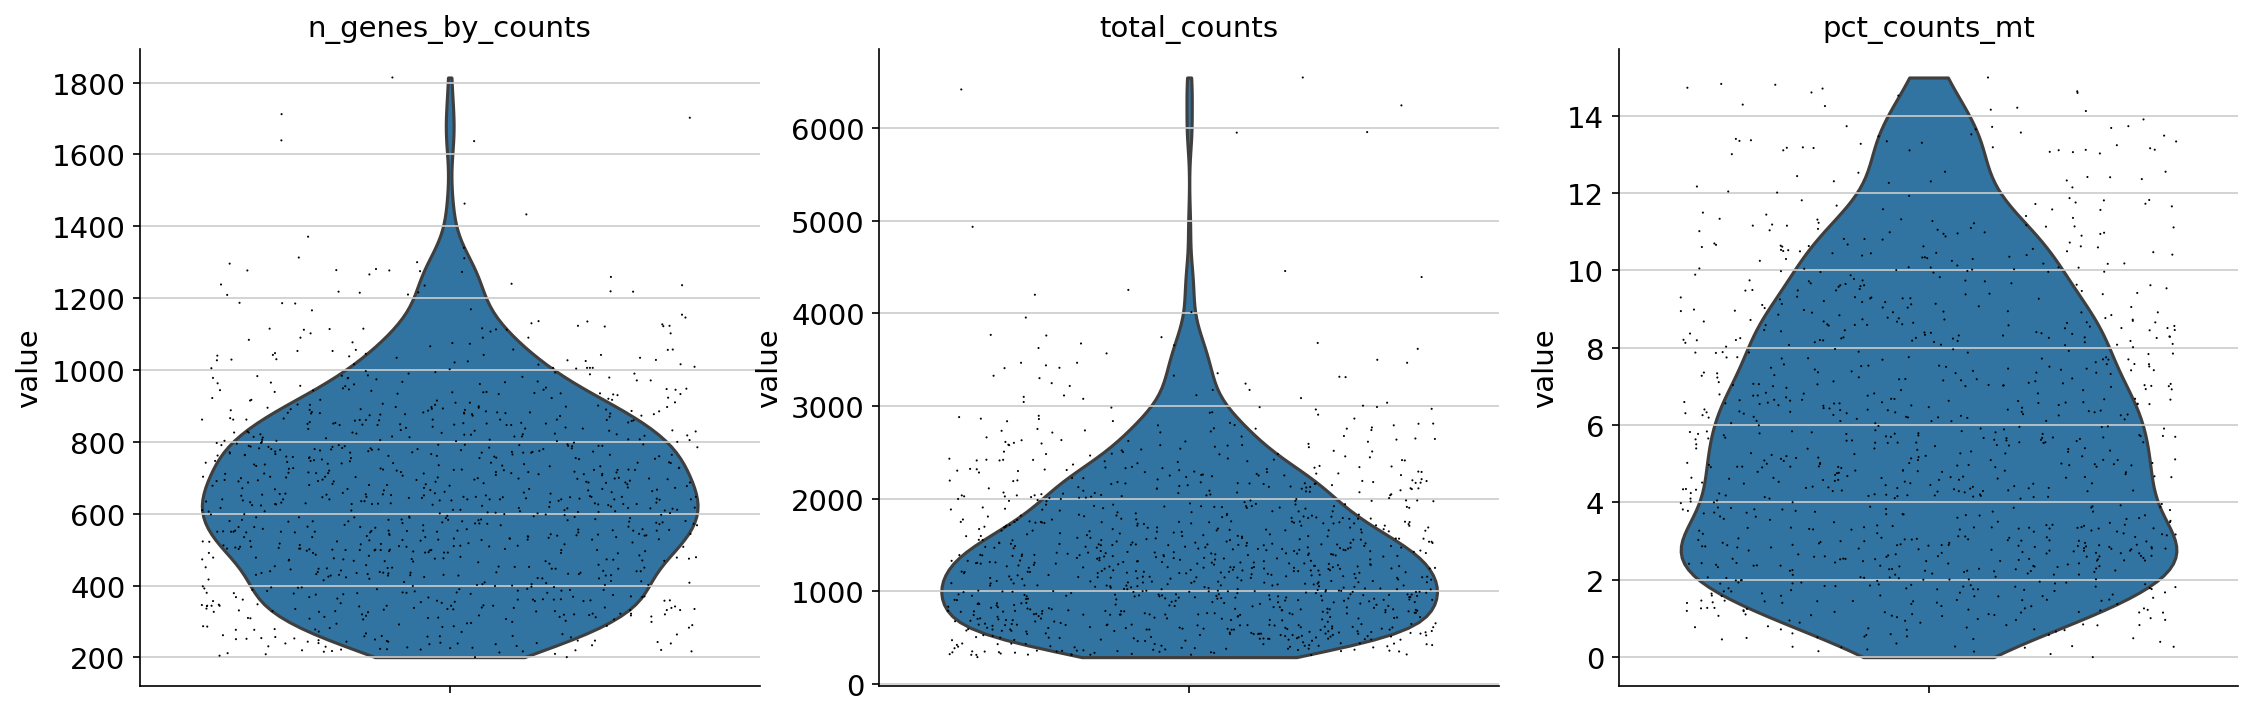

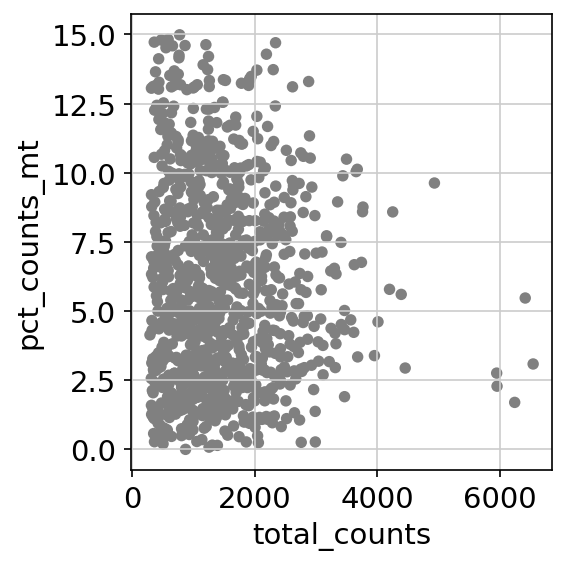

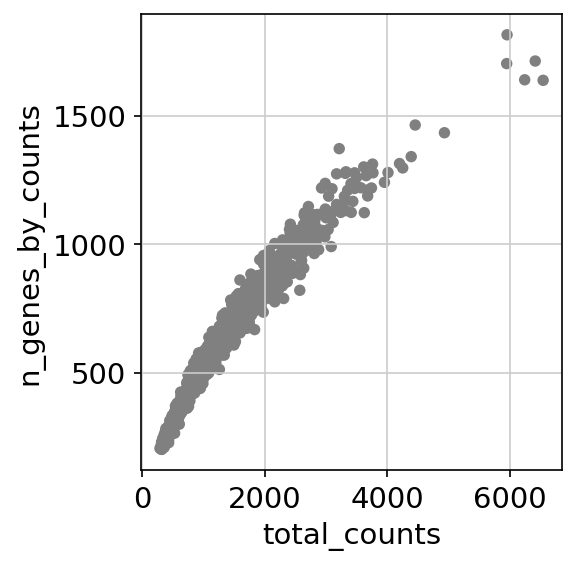

In [12]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, save='rna_fly_qc')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

# scrublet

In [13]:
sc.external.pp.scrublet(adata, threshold=0.2)

/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/user/leuven/330/vsc33042/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 44.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.6%


(<Figure size 1200x450 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot:title={'center':'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

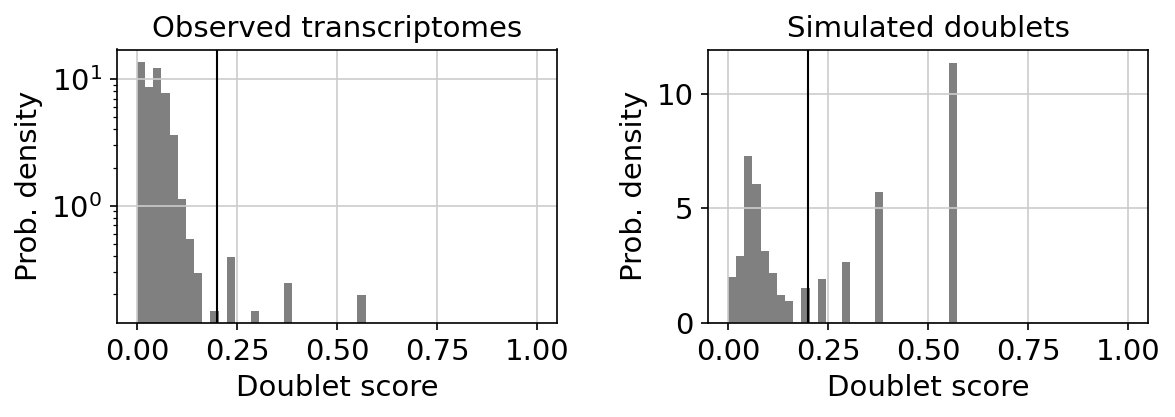

In [14]:
sc.external.pl.scrublet_score_distribution(adata)

In [15]:
adata = adata[adata.obs['predicted_doublet']==False]

/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


# normalize

In [16]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/user/leuven/330/vsc33042/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [20]:
adata.X

<973x6916 sparse matrix of type '<class 'numpy.float32'>'
	with 635983 stored elements in Compressed Sparse Row format>

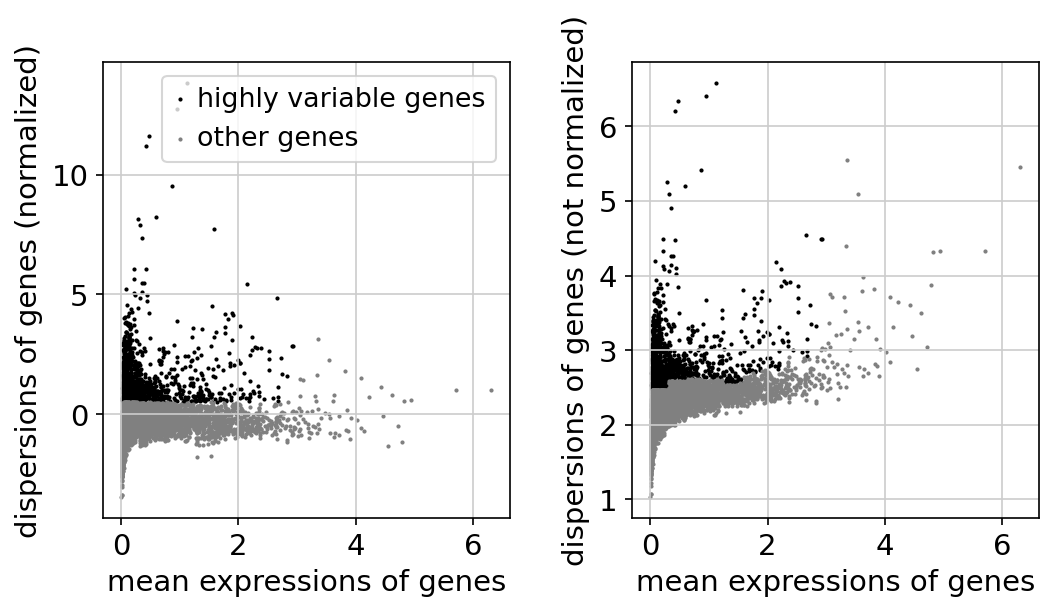

In [21]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [22]:
# adata = adata[:, adata.var.highly_variable]

In [23]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [24]:
sc.pp.scale(adata, max_value=10)

# pca

/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


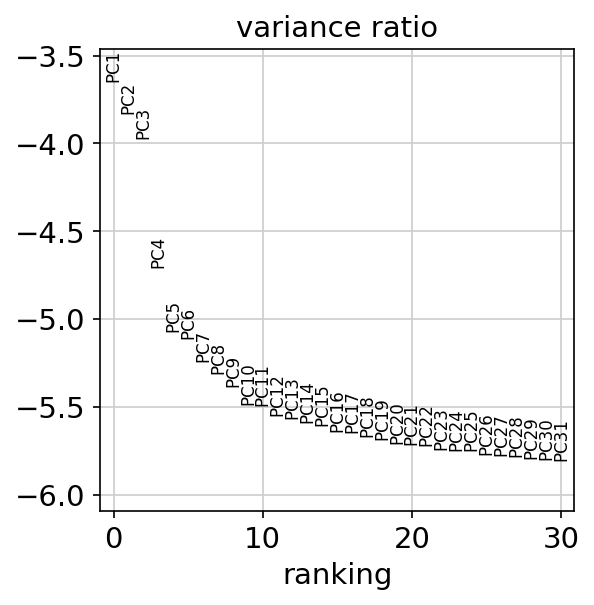

In [25]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [26]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep='X_pca')

In [27]:
sc.tl.umap(adata)
sc.tl.tsne(adata)

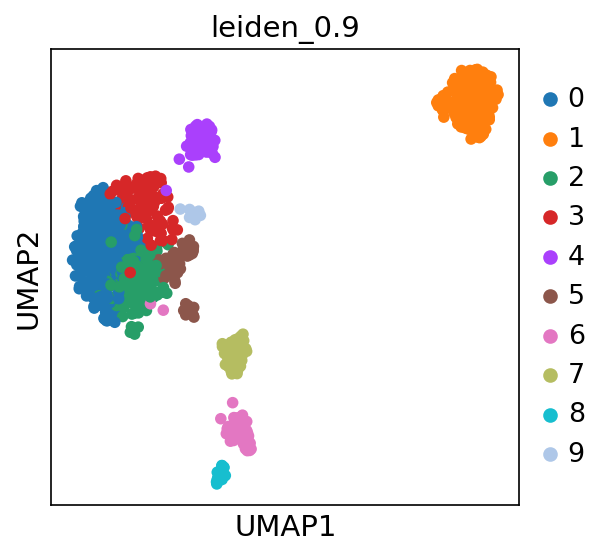

In [28]:
res = 0.9
sc.tl.leiden(adata, resolution=res, key_added='leiden_'+str(res))
sc.pl.umap(adata, color='leiden_0.9')

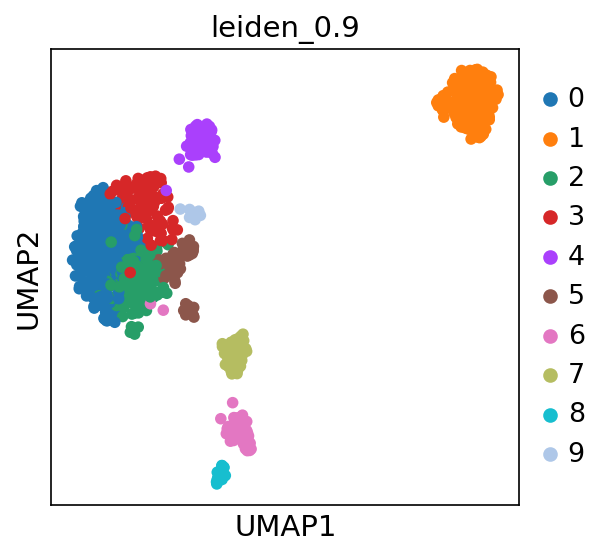

In [29]:
res = 0.9
sc.tl.leiden(adata, resolution=res, key_added='leiden_'+str(res))
sc.pl.umap(adata, color='leiden_'+str(res))

# annotation

In [30]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'Tm1',
     '1': 'T1',
     '2': 'Tm1',
     '3': 'Tm1',
     '4': 'Mi1',
     '5': 'Unk',
     '6': 'γ KC', # or other
     '7': 'α/β KC',
    '8': "α'/β' KC",
    '9': 'Unk'
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['cell_type'] = adata.obs['leiden_0.9'].map(cluster2annotation).astype('category')

In [31]:
markers = ['ey', 'prt', # KC 4, 0, 1, 10, 7, 6
           'DAT',  # alpha/beta KC | 10
           'ab', 'zfh2', #Gamma KC | 0/4, 6
           'oc', 'Awh', #T1 | 5
           'Mef2', 'TfAP-2', #Tm1 | 2
           'repo', #glia | 6?
           'C15', 'kn', 'acj6', #OPN | 3
           'bsh', 'hth'] #Mi1 | 8

In [32]:
markers_dict = {
    'Tm1': ['TfAP-2', 'bsh'],
    'T1': ['oc', 'Awh'],
    'Mi1': ['bsh', 'hth'],
    'KC': ['ey', 'prt'],
    'γ KC': ['ab', 'zfh2'],
    'α/β KC': 'DAT',  # alpha/beta KC | 10
    'glia': 'repo', #glia | 6?
    'OPN': ['kn', 'acj6', 'oaz'],
}

In [33]:
list(adata.obs['cell_type'].unique())

['γ KC', 'Tm1', 'T1', 'Unk', 'α/β KC', 'Mi1', "α'/β' KC"]

In [34]:
markers = "TfAP-2 Tk Eaat1 Awh oc sosie bsh hth acj6 kn  mamo ey DAT Mef2 ab sNPF Imp".split()

In [35]:
celltypes = "Tm1 T1 Mi1 gKC abKC abpKC Unk".split()
celltypes = ['Tm1',
            'T1',
            'Mi1',
            'γ KC',
            'α/β KC',
            "α'/β' KC",
            'Unk',
            ]

In [36]:
sc.set_figure_params(figsize=(5,5), vector_friendly=False)

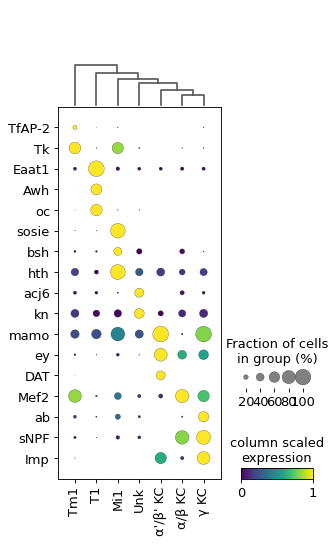

In [37]:
sc.tl.dendrogram(adata, groupby="cell_type")
sc.pl.dotplot(adata, markers, 'cell_type', standard_scale='var', colorbar_title='column scaled\nexpression', cmap='viridis', save='fly_dotplot.svg', categories_order = celltypes, dendrogram=True, swap_axes=True)

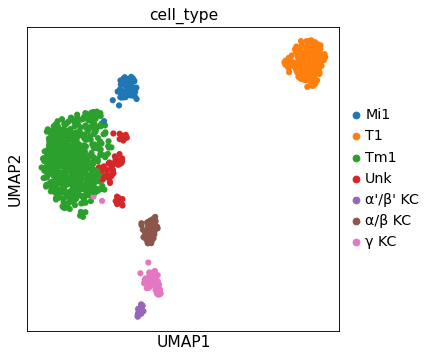

In [38]:
sc.pl.umap(adata, color='cell_type', save='rna_fly_annotated.svg', palette = sns.color_palette("tab10"))

i had to replace     size_factor = lf.ca['nUMI'] with     size_factor = lf.ca['total_counts']

# markers

In [39]:
adata.obs['cell_type'].unique()

['γ KC', 'Tm1', 'T1', 'Unk', 'α/β KC', 'Mi1', 'α'/β' KC']
Categories (7, object): ['γ KC', 'Tm1', 'T1', 'Unk', 'α/β KC', 'Mi1', 'α'/β' KC']

In [76]:
sc.tl.rank_genes_groups(adata, groupby="cell_type", method="logreg")
# sc.pl.rank_genes_groups(adata, save='de.png')

/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


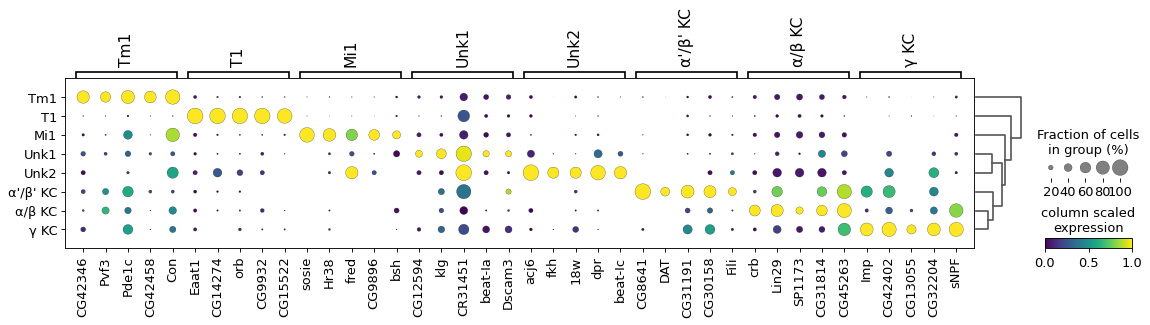

In [78]:
ngenes = 5
markers = pd.DataFrame.from_records(adata.uns["rank_genes_groups"]["names"])
mdict = markers.iloc[0:ngenes].to_dict("list")
sc.tl.dendrogram(adata, groupby="cell_type")
sc.pl.dotplot(
    adata,
    mdict,
    "cell_type",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    cmap="viridis",
    dendrogram=True,
    save="cluster_markergenes_dotplot.pdf",
    swap_axes=False,
)
# sc.pl.umap(adata, color='cell_type', save='annotated.svg', palette = sns.color_palette('husl', 24))

# write adata

In [65]:
adata.write("20210517_adata")

# write loom file

In [40]:
# Load class
class loom_file_creation:
    import os

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import scanpy as sc
    import seaborn as sns

    def __init__(self, dgem, meta):
        import numpy as np
        import pandas as pd

        self.dgem = dgem
        self.meta = meta
        self.CPM = self.dgem / self.dgem.sum() * 1e6
        self.logCPM = np.log1p(self.CPM)
        self.metaJson = {}
        self.metaJson["metrics"] = []
        self.metaJson["annotations"] = []
        # initialize counters
        self.default_embedding_counter = 0
        self.embeddings_id = 1
        self.clusterings_id = 0
        self.col_attrs_counter = 0
        self.row_attrs_counter = 0
        self.attrs_counter = 0
        # add other embeddings
        self.Embeddings_X = pd.DataFrame()
        self.Embeddings_Y = pd.DataFrame()
        # add clusterings
        self.clusterings = pd.DataFrame(index=self.meta.index)

    def add_default_embedding(self, x, y, name="default"):
        self.main_dr = self.meta[[x, y]]
        self.main_dr.columns = ["_X", "_Y"]
        self.metaJson["embeddings"] = [{"id": -1, "name": name}]
        self.default_embedding_counter = 1

    def add_other_embedding(self, x, y, name):
        # every extra embedding is put in these dataframes as columns
        self.Embeddings_X[str(self.embeddings_id)] = self.meta[x]
        self.Embeddings_Y[str(self.embeddings_id)] = self.meta[y]
        self.metaJson["embeddings"].append({"id": self.embeddings_id, "name": name})
        self.embeddings_id += 1

    # here you can add description of the cluster
    def add_numeric_clustering(self, res, group, name, annotated=None):
        # add all cluster IDs to meta
        if self.clusterings_id == 0:
            self.metaJson["clusterings"] = [
                {
                    "id": self.clusterings_id,
                    "group": group,
                    "name": name,
                    "clusters": [],
                }
            ]
        if self.clusterings_id > 0:
            # add all cluster IDs to meta
            self.metaJson["clusterings"].append(
                {
                    "id": self.clusterings_id,
                    "group": group,
                    "name": name,
                    "clusters": [],
                }
            )
        # get annotation for numeric values (count annotation for each numeric value, take the annotation that occurs the most)
        if annotated in self.meta.columns:
            annotation_dataframe = pd.DataFrame(
                meta.groupby(res)[annotated].value_counts().groupby(res).head(n=1)
            )
            annotation_dataframe.columns = ["test"]
            annotation_dataframe = annotation_dataframe.reset_index()
            annotation_dataframe.index = annotation_dataframe[res]
            annotation_dataframe.drop(res, axis=1, inplace=True)
            annotation_dataframe.drop("test", axis=1, inplace=True)
            for i in range(max(set([int(x) for x in self.meta[res]])) + 1):
                clustDict = {}
                clustDict["id"] = i
                clustDict["description"] = annotation_dataframe.loc[i, annotated]
                self.metaJson["clusterings"][self.clusterings_id]["clusters"].append(
                    clustDict
                )
        else:
            for i in range(max(set([int(x) for x in self.meta[res]])) + 1):
                clustDict = {}
                clustDict["id"] = i
                clustDict["description"] = f"Unannotated Cluster {i}"
                self.metaJson["clusterings"][self.clusterings_id]["clusters"].append(
                    clustDict
                )
        # add cluster IDs for every cell to dataframe
        self.clusterings[str(self.clusterings_id)] = self.meta[res].values.astype(
            np.int64
        )
        # increase counter
        self.clusterings_id += 1

    def dfToNamedMatrix(df):
        arr_ip = [tuple(i) for i in df.values]
        dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
        arr = np.array(arr_ip, dtype=dtyp)
        return arr

    def make_col_attributes(self):
        # define col attributes
        if self.embeddings_id > 1:
            if self.clusterings_id > 0:
                self.col_attrs = {
                    "CellID": np.array(self.meta.index),
                    "Embedding": dfToNamedMatrix(self.main_dr),
                    "Embeddings_X": dfToNamedMatrix(self.Embeddings_X),
                    "Embeddings_Y": dfToNamedMatrix(self.Embeddings_Y),
                    "Clusterings": dfToNamedMatrix(self.clusterings),
                    "ClusterID": np.array(
                        self.clusterings[str(self.clusterings_id - 1)].values
                    ),
                }
            else:
                self.col_attrs = {
                    "CellID": np.array(self.meta.index),
                    "Embedding": dfToNamedMatrix(self.main_dr),
                    "Embeddings_X": dfToNamedMatrix(self.Embeddings_X),
                    "Embeddings_Y": dfToNamedMatrix(self.Embeddings_Y),
                }
        elif self.clusterings_id > 0:
            self.col_attrs = {
                "CellID": np.array(self.meta.index),
                "Embedding": dfToNamedMatrix(self.main_dr),
                "Clusterings": dfToNamedMatrix(self.clusterings),
                "ClusterID": np.array(
                    self.clusterings[str(self.clusterings_id - 1)].values
                ),
            }
        else:
            self.col_attrs = {
                "CellID": np.array(self.meta.index),
                "Embedding": dfToNamedMatrix(self.main_dr),
            }
        self.col_attrs_counter = 1

    def add_annotation(self, annotation):
        if self.col_attrs_counter < 1:
            print("first run make_col_attributes")
        self.metaJson["annotations"].append(
            {"name": annotation, "values": list(set(self.meta[annotation].values))}
        )
        self.col_attrs[annotation] = np.array(self.meta[annotation].values)

    def add_metric(self, metric):
        if self.col_attrs_counter < 1:
            print("first run make_col_attributes")
        self.metaJson["metrics"].append({"name": metric})
        self.col_attrs[metric] = np.array(self.meta[metric].values)

    def make_row_attributes(self):
        self.row_attrs = {"Gene": np.array(self.dgem.index)}
        self.row_attrs_counter = 1

    def make_attributes(self):
        import base64
        import json
        import zlib

        self.attrs = {"MetaData": json.dumps(self.metaJson)}
        self.attrs["MetaData"] = base64.b64encode(
            zlib.compress(json.dumps(self.metaJson).encode("ascii"))
        ).decode("ascii")
        self.attrs_counter = 1

    def create_loomfile(self, path):
        import loompy as lp

        if (
            self.col_attrs_counter == 1
            and self.row_attrs_counter == 1
            and self.default_embedding_counter == 1
            and self.attrs_counter == 1
        ):
            lp.create(
                filename=path,
                layers=(self.dgem).values,
                row_attrs=self.row_attrs,
                col_attrs=self.col_attrs,
                file_attrs=self.attrs,
            )
        else:
            print(
                "Make sure that col_attr, row_attrs, attrs and embedding have been run"
            )


def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [18]:
adata_raw = sc.read_10x_mtx(
    'simulate_10x/R74/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata_raw.var_names_make_unique()

adata_raw = adata_raw[
    adata.obs.index
]  # instead of filtering, just subset based on the previous adata
test = adata.obs.index == adata_raw.obs.index
np.unique(test)

array([ True])

In [45]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'Tm1',
     '1': 'T1',
     '2': 'Tm1',
     '3': 'Tm1',
     '4': 'Mi1',
     '5': 'Unk',
     '6': 'g-KC', # or other
     '7': 'ab-KC',
    '8': "a'/b'-KC",
    '9': 'Unk'
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['cell_type'] = adata.obs['leiden_0.9'].map(cluster2annotation).astype('category')

In [46]:
# make sure cell types contain no illegal characters such as γ
df = []
meta = []
df = pd.DataFrame(
    adata_raw.X.toarray(), columns=adata_raw.var_names, index=adata_raw.obs_names
).T  # remove .toarray() if not necessary
meta = adata.obs
loomfile = loom_file_creation(df, meta)
meta["UMAP_X"] = adata.obsm["X_umap"][:, 0]
meta["UMAP_Y"] = adata.obsm["X_umap"][:, 1]
loomfile.add_default_embedding(x="UMAP_X", y="UMAP_Y")
meta["TSNE_X"] = adata.obsm["X_tsne"][:, 0]
meta["TSNE_Y"] = adata.obsm["X_tsne"][:, 1]
loomfile.add_other_embedding(x="TSNE_X", y="TSNE_Y", name="tsne")
# loomfile.add_numeric_clustering(res="leiden_0.9",group="leiden_0.9",name="leiden_0.9",annotated='cell_type')
loomfile.add_numeric_clustering(
    res="leiden_0.9", group="leiden_0.9", name="leiden_0.9", annotated="cell_type"
)
# loomfile.add_numeric_clustering(res="integrated_snn_res.2",group="Louvain",name="Unannotated")
loomfile.make_col_attributes()
loomfile.make_row_attributes()
# loomfile.add_annotation(annotation="cell_type")
# loomfile.add_annotation(annotation="leiden_1")
loomfile.add_annotation(annotation="cell_type")

loomfile.add_metric(metric="total_counts")
loomfile.add_metric(metric="n_genes")
loomfile.make_attributes()
loomfile.create_loomfile("plts_pub/hydrop-fly_finalann.loom")

In [734]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [736]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'Tm1',
     '1': 'T1',
     '2': 'Tm1',
     '3': 'Tm1',
     '4': 'Mi1',
     '5': 'Unk',
     '6': 'gKC', # or other
     '7': 'abKC',
    '8': 'abpKC',
    '9': 'Unk'
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['cell_type'] = adata.obs['leiden_0.9'].map(cluster2annotation).astype('category')

we used log, cp10k normalised data! subset the raw adata on the filtered cells

# plot markers

In [14]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import loompy as lp
import matplotlib as mpl
import matplotlib.pyplot as plt

def colourplot_loom(loom_path,genes,CPM=True,log=True,fig_size=(10,10),factor=225/255,T=0.8,marker_size=5, outname='figure.svg'):
    f_lf = loom_path
    lf = lp.connect( f_lf, mode="r",validate=False)
    gene_index = []
    for gene in genes:
        gene_index.append(np.where(lf.ra.Gene==gene)[0][0])
    gene_index = sorted(gene_index)
    exprMat_subset = pd.DataFrame( lf[gene_index,:], index=lf.ra.Gene[gene_index], columns=lf.ca.CellID )
    embeddings = pd.DataFrame(lf.ca['Embedding'],index=lf.ca.CellID)    
    size_factor = lf.ca['total_counts']
    if CPM:
        exprMat_subset = exprMat_subset/size_factor*1e6
    if log:
        exprMat_subset = np.log1p(exprMat_subset)
    lf.close()
    df = exprMat_subset
    meta = embeddings
    x,y = '_X','_Y'
    markeredge_color = 'k'
    markeredge_width = 0
    if len(genes)>1:
        plotting_r = df.loc[genes,df.loc[genes].sum()>0]
    else:
        a = df.loc[genes]>0
        plotting_r = df.loc[genes,df.columns[np.array(a)[0]]    ]
    #plotting_r = plotting_r - 1
    plotting_r_Z = plotting_r.T    
    plotting_min, plotting_max = plotting_r_Z.min(), plotting_r_Z.max()
    plotting_r_Z_min_max = (plotting_r_Z-plotting_min)/(plotting_max-plotting_min)
    #plotting_r_Z_min_max = plotting_r_Z_min_max/plotting_r_Z_min_max.max()
    plotting_r_Z_min_max = plotting_r_Z_min_max.clip(upper=T).copy()
    plotting_r_Z_min_max = plotting_r_Z_min_max*factor*1/T
    sorting = pd.DataFrame(plotting_r_Z_min_max.T.sum())
    sorting.columns = ["sum"]
    sorting = sorting.sort_values(by="sum")
    plotting_cells = sorting.index
    colour = []
    for cell in plotting_r_Z_min_max.index:
        red = plotting_r_Z_min_max.loc[cell,genes[0]]
        green = 0
        blue = 0
        if len(genes)>1:
            green = plotting_r_Z_min_max.loc[cell,genes[1]]
        if len(genes)>2:
            blue = plotting_r_Z_min_max.loc[cell,genes[2]]
        colourarr = np.nan_to_num([red, green, blue, 1])
        colour.append(mpl.colors.to_rgba(tuple(colourarr)))

    plotting_r_Z_min_max['colour'] = colour
    plotting_r_Z_min_max = plotting_r_Z_min_max.fillna(0)
    plt.figure(figsize=fig_size)
    plt.scatter(meta[x],meta[y],s=marker_size,
                c='gray',
                edgecolors = markeredge_color,linewidths=markeredge_width)
    plt.scatter(meta.loc[plotting_cells,x],meta.loc[plotting_cells,y],s=marker_size,
                c=plotting_r_Z_min_max.loc[plotting_cells,'colour'],
                edgecolors = markeredge_color,linewidths=markeredge_width)
    plt.grid(b=None)

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='logcpm('+genes[0]+')', markerfacecolor='r', markersize=5),
        Line2D([0], [0], marker='o', color='w', label='logcpm('+genes[1]+')', markerfacecolor='g', markersize=5),
        Line2D([0], [0], marker='o', color='w', label='logcpm('+genes[2]+')', markerfacecolor='b', markersize=5),
    ]
    plt.legend(handles=legend_elements)
    plt.savefig(outname, dpi=50)

# plts pub

remember, data in matrix is log scaled and normalised to cp10k!

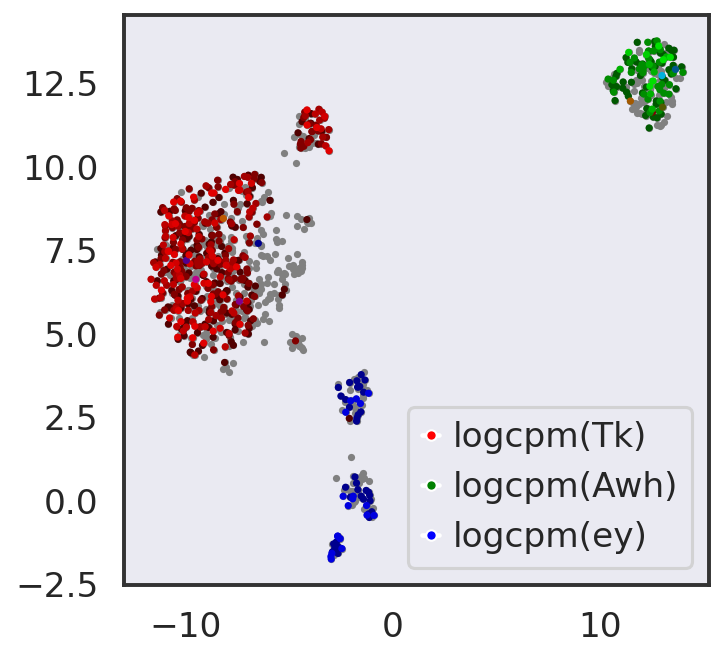

In [19]:
genes = 'Tk Awh ey'.split()
outname = str(genes).replace("', '", '_')
outname = str(outname).replace("['", '')
outname = str(outname).replace("']", '')

colourplot_loom('plts_pub/hydrop-fly_finalann.loom',genes,CPM=False,log=True,fig_size=(5,5),factor=225/255,T=0.8,marker_size=12, outname='plts_pub/'+outname+'_nice_log.svg')

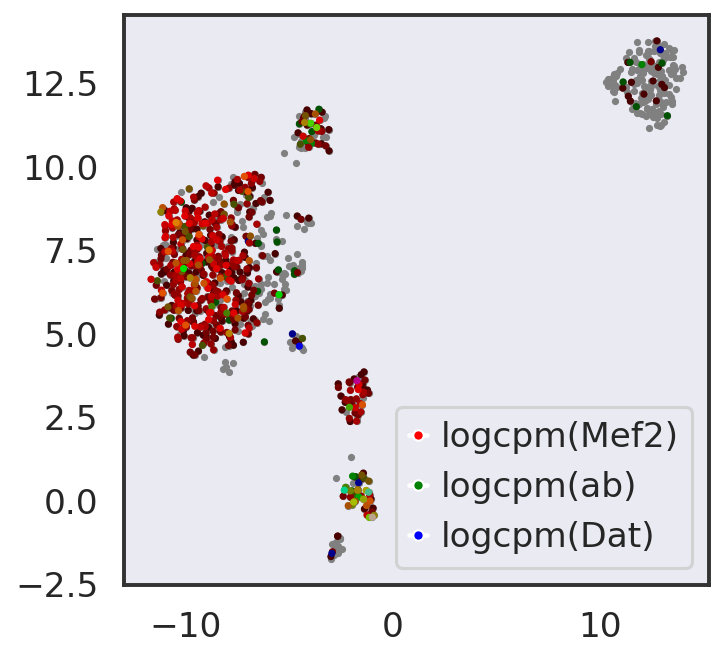

In [18]:
genes = 'Mef2 ab Dat'.split()
outname = str(genes).replace("', '", '_')
outname = str(outname).replace("['", '')
outname = str(outname).replace("']", '')

colourplot_loom('plts_pub/hydrop-fly_finalann.loom',genes,CPM=False,log=True,fig_size=(5,5),factor=225/255,T=0.8,marker_size=12, outname='plts_pub/'+outname+'_nice_log.svg')

In [549]:
from scipy.stats import gaussian_kde
context = 'talk'
style = 'darkgrid'
markersize=25

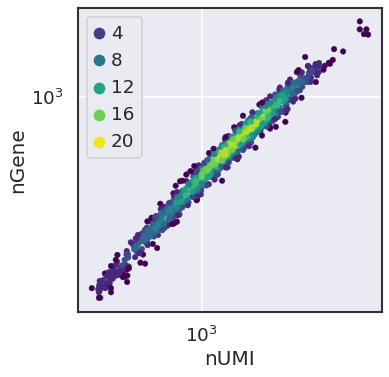

0.2693220505234179
20.499016556892293


In [552]:
sns.set_context(context)
sns.set_style(style, {'axes.linewidth': 1, 'axes.edgecolor':'.20'})

sample = 'merged'
category = 'frip'
xvar = 'total_counts'
yvar = 'n_genes'
x=np.log10(adata.obs[xvar])
y=np.log10(adata.obs[yvar])

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
bins = np.linspace(z.min(), z.max(), 10)
digitized = np.digitize(z, bins)
bin_means = [z[digitized == i].mean() for i in range(1, len(bins))]
digitized_rescaled = np.interp(digitized, (digitized.min(), digitized.max()), (z.min(), z.max()))

ax = sns.scatterplot(data = adata.obs, x=xvar, y=yvar, hue=digitized_rescaled, palette='viridis', edgecolor=None, s=markersize)
ax.set(xscale='log')
ax.set(yscale='log')

ax.set_aspect('equal', adjustable='box')
ax.set_aspect(1./ax.get_data_ratio())

import matplotlib.ticker as mtick
ax.set_xlabel('nUMI')
ax.set_ylabel('nGene')

fig = plt.gcf()
fig.savefig('plts_pub/umis_genes_markersize'+str(markersize)+'.svg', dpi=100)
plt.show()

print(z.min())
print(z.max())

In [27]:
adata.obs.median()

n_genes               640.000000
n_genes_by_counts     640.000000
total_counts         1307.000000
total_counts_mt        66.000000
pct_counts_mt           5.555556
doublet_score           0.041169
predicted_doublet       0.000000
dtype: float64

In [28]:
adata.obs.mean()

n_genes               655.301131
n_genes_by_counts     653.631038
total_counts         1458.669067
total_counts_mt        85.339157
pct_counts_mt           5.941638
doublet_score           0.045956
predicted_doublet       0.000000
dtype: float64

# improved violin plots

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
df = adata.obs
df_numis = df.copy()
df_ngenes = df.copy()
df_numis['count'] = df['total_counts']
df_ngenes['count'] = df['n_genes']
df_numis['count_type'] = 'numis'
df_ngenes['count_type'] = 'ngenes'
df_count = df_numis.append(df_ngenes, ignore_index=True)

In [8]:
context = "talk"
style = "darkgrid"
markersize = 25
plt.close()
sns.set_context(context)
sns.set_style(style, {"axes.linewidth": 1, "axes.edgecolor": ".20"})

In [9]:
df_count['count_type'].value_counts()

numis     973
ngenes    973
Name: count_type, dtype: int64

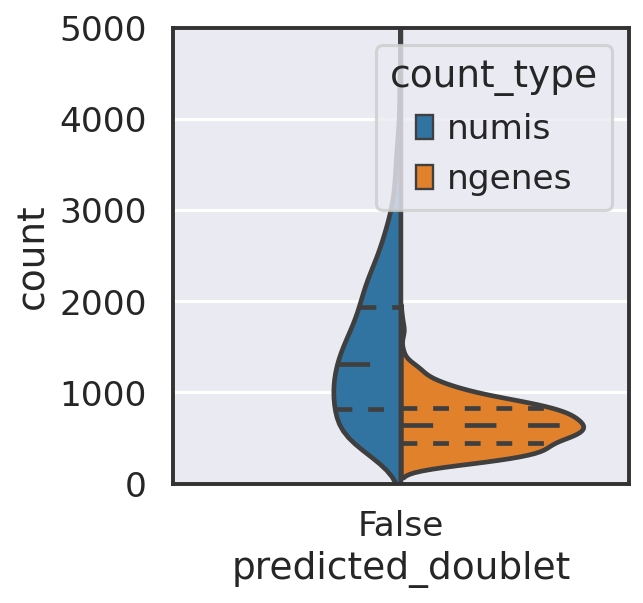

In [10]:
ax = sns.violinplot(data=df_count, y='count', x='predicted_doublet', hue='count_type', split=True, inner="quartile", scale='area')
plt.ylim([0,5000])

ax.set_aspect("equal", adjustable="box")
ax.set_aspect(1.0 / ax.get_data_ratio())
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.savefig('plts_pub/fly_counts_ylim5000.svg')

plt.show()

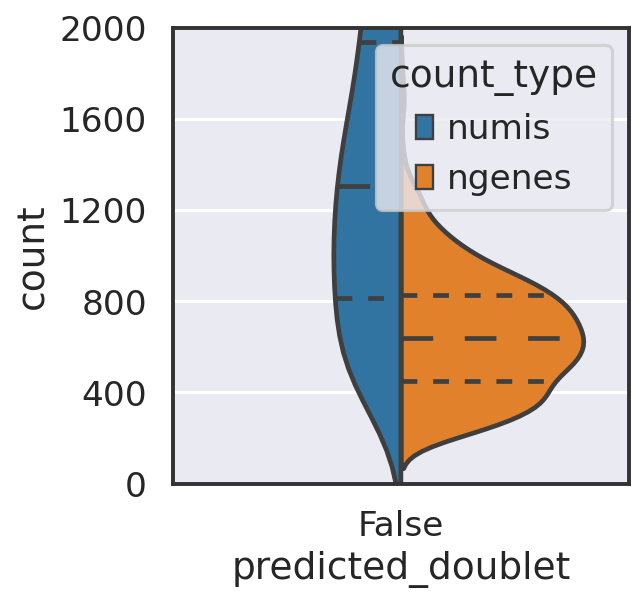

In [11]:
ax = sns.violinplot(data=df_count, y='count', x='predicted_doublet', hue='count_type', split=True, inner="quartile", scale='area')
plt.ylim([0,2000])

ax.set_aspect("equal", adjustable="box")
ax.set_aspect(1.0 / ax.get_data_ratio())
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.savefig('plts_pub/fly_counts_ylim2000.svg')
plt.show()

These violin plots were merged together in Illustrator